# State Farm Distracted Driver Detection

## Libraries

In [1]:
# support image quality check
!pip install Pillow
# visual process bar
!pip install tqdm

In [2]:
from collections import defaultdict
import os

import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm


## 0. Load Data

In [3]:
df = pd.read_csv('/kaggle/input/state-farm-distracted-driver-detection/driver_imgs_list.csv')
df.head(5)

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


## 1. Data Clean / Understanding

### 1.0 Clean Missing Values

In [4]:
# Add your implementation

### 1.1 Distribution
Goal: Understand the distribution of columns in the data set.
1. Are all of the  columns normally distributed?

Impacts:
1. If the data is not normally distributed, the training process may be biased towards the majority class.

Precondition:
1. Data is loaded.
2. Missing values are handled.
   a. reason: missing values are not counted in the distribution.

Action: Find the distribution of every column in the data set, totally 3 columns.
1. subject
2. classname
3. img

#### 1.1.1 subject distribution

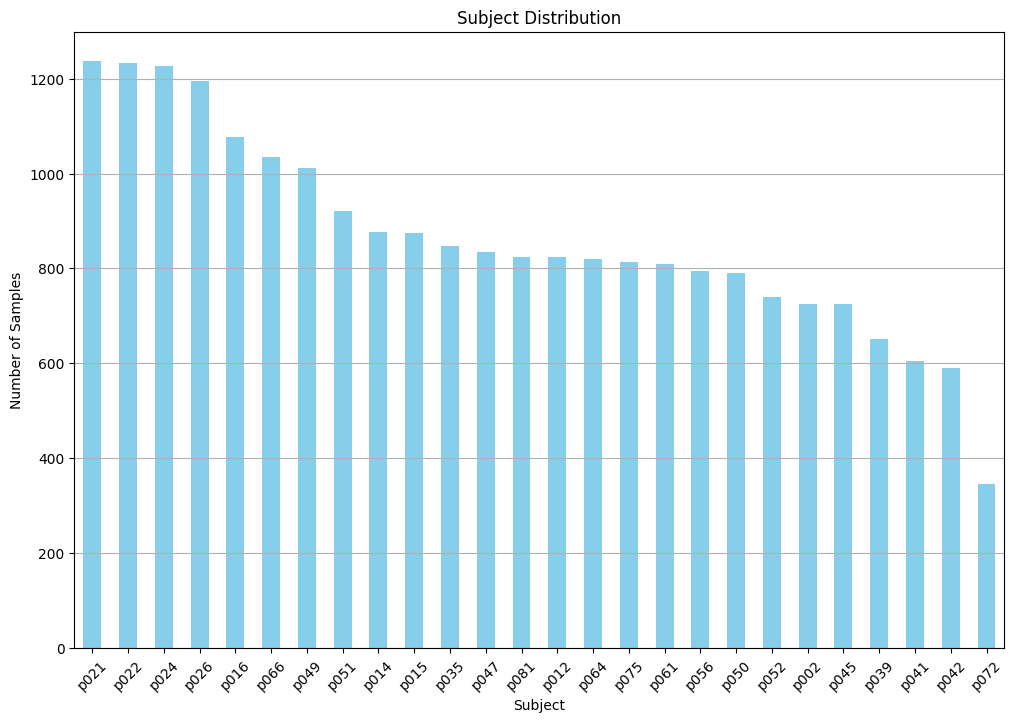

In [5]:
# Count the number of occurrences of each class
class_counts = df['subject'].value_counts()

# Plot the distribution
plt.figure(figsize=(12, 8))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Subject Distribution')
plt.xlabel('Subject')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

#### 1.1.2 classname distribution

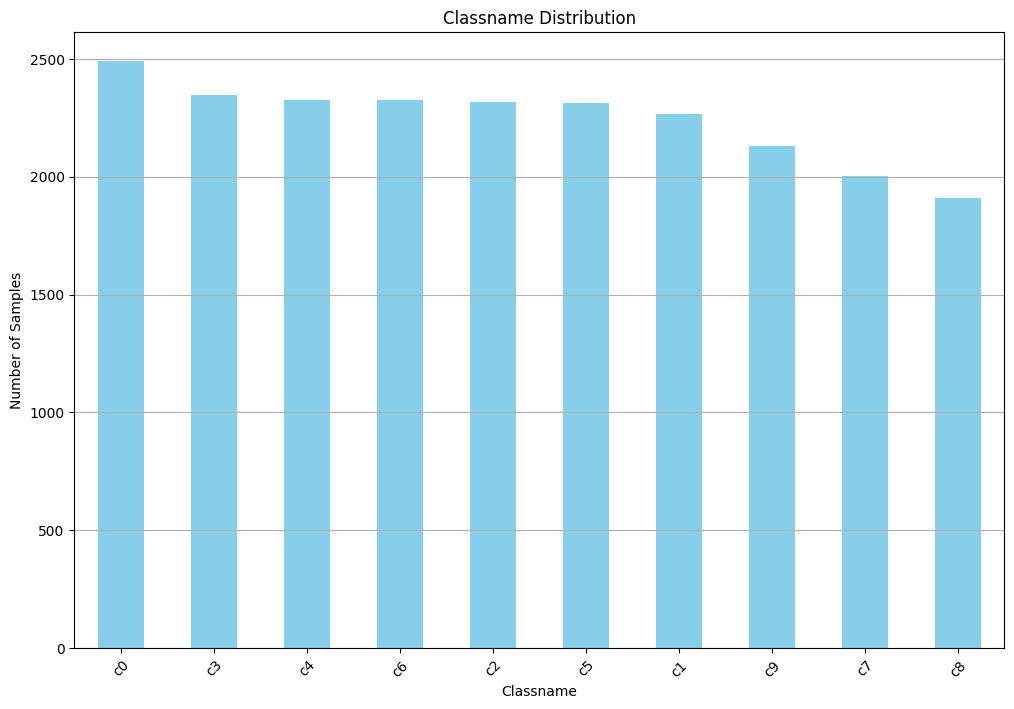

In [6]:
# Count the number of occurrences of each class
class_counts = df['classname'].value_counts()

# Plot the distribution
plt.figure(figsize=(12, 8))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Classname Distribution')
plt.xlabel('Classname')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

#### 1.1.3 img distribution
To visualize it may take quite a long time since img is likely to be unique.
So, instead of render every single bar, we can instead see if every of them are unique.

In [7]:
# Check the total number of 'img' entries
total_entries = len(df['img'])

# Check the number of unique 'img' entries
unique_entries = df['img'].nunique()

# Print the results
print(f"Total number of image entries: {total_entries}")
print(f"Number of unique image entries: {unique_entries}")

# Check if every image entry is unique
if total_entries == unique_entries:
    print("Every image entry is unique.")
else:
    print(f"There are {total_entries - unique_entries} duplicate image entries.")

Total number of image entries: 22424
Number of unique image entries: 22424
Every image entry is unique.


### Note: Before the below items (1.2, 1.3, 1.4), it will better to check what kind of inputs each model want. May be some model don't need to resize the image, simplify the color, etc.

### 1.2 Image Quality Check
**Here might be tricky**

Image Quality Check: 
Check if all images are of 
1. consistent quality, 
2. resolution,
3. orientation. 
4. Identify any corrupted or unreadable images.

**Note**: Based on the suggestion from James, since those image are already labeled, they are very likely to be okay, such the as the resolution, orientation, and the size.

Action:
Just in case, 

1. write the code to check integrity for easy items, such as
  a. if every single img has the same size
  b. resolution same for each img? (how many pixels are displayed per inch of an image)
2. Manually random choose a portion of images (may be quickly galance 1000 images?), to build confidence:
  a. same orientation?
  b. any corrupted data?

### 1.2.1 Coding Part for Simple Items
Assignee: Jingchao Zhong

Note for the implementation:
By observation, the `img` column of `driver_imgs_list.csv` only contain the image filenames for the training data set, which means the image files are located in the `imgs/train` folder. Thus, to check the quality of all available imgs, I scan directly for the images under `imgs` folder.

In [8]:
class ImageScanner:
    def __init__(self, path):
        self.path = path
        self.image_files = self._get_all_jpg_files()
        self.statistics = {
            "total_images": len(self.image_files),
            "same_size": 0,
            "different_size": 0,
            "same_resolution": 0,
            "different_resolution": 0,
            "reference_size": None,
            "reference_resolution": None,
            "size_issues": defaultdict(list),
            "resolution_issues": defaultdict(list)
        }

    def _get_all_jpg_files(self):
        """
        Retrieve all jpg files in the specified directory, including subdirectories.
        """
        jpg_files = []
        for root, _, files in os.walk(self.path):
            for file in files:
                if file.lower().endswith(".jpg"):
                    jpg_files.append(os.path.join(root, file))
        return jpg_files

    @staticmethod
    def _get_image_size_and_resolution(image_path):
        """
        Get the size and resolution of an image.
        """
        with Image.open(image_path) as img:
            size = img.size
            resolution = img.info.get('dpi', (None, None))
        return size, resolution

    def scan_images(self):
        if not self.image_files:
            print("No JPG images found in the provided path.")
            return

        reference_size, reference_resolution = self._get_image_size_and_resolution(self.image_files[0])
        self.statistics["reference_size"] = reference_size
        self.statistics["reference_resolution"] = reference_resolution

        for image_path in tqdm(self.image_files, desc="Scanning images", ncols=100):
            current_size, current_resolution = self._get_image_size_and_resolution(image_path)
            
            if current_size == reference_size:
                self.statistics["same_size"] += 1
            else:
                self.statistics["different_size"] += 1
                self.statistics["size_issues"][current_size].append(image_path)
                
            if current_resolution == reference_resolution:
                self.statistics["same_resolution"] += 1
            else:
                self.statistics["different_resolution"] += 1
                self.statistics["resolution_issues"][current_resolution].append(image_path)

    def display_statistics(self):
        """
        Display the statistics after scanning the images.
        """
        print(f"Total images scanned: {self.statistics['total_images']}")

        # Size statistics
        print(f"\nSize Statistics:")
        print(f"Images with same size as reference: {self.statistics['same_size']}")
        print(f"Images with different size: {self.statistics['different_size']}")
        print(f"Reference image size: {self.statistics['reference_size']}")

        if self.statistics["size_issues"]:
            print("\nDetails of images with different sizes:")
            for size, paths in self.statistics["size_issues"].items():
                print(f"Size: {size}")
                for p in paths:
                    print(f"   - {p}")

        # Resolution statistics
        print(f"\nResolution Statistics:")
        print(f"Images with same resolution as reference: {self.statistics['same_resolution']}")
        print(f"Images with different resolution: {self.statistics['different_resolution']}")
        print(f"Reference image resolution: {self.statistics['reference_resolution']}")

        if self.statistics["resolution_issues"]:
            print("\nDetails of images with different resolutions:")
            for resolution, paths in self.statistics["resolution_issues"].items():
                print(f"Resolution: {resolution}")
                for p in paths:
                    print(f"   - {p}")

                    
print("start processing...")
path = '/kaggle/input/state-farm-distracted-driver-detection/imgs/'
scanner = ImageScanner(path)
scanner.scan_images()
scanner.display_statistics()

start processing...


Scanning images: 100%|█████████████████████████████████████| 102150/102150 [12:12<00:00, 139.48it/s]

Total images scanned: 102150

Size Statistics:
Images with same size as reference: 102150
Images with different size: 0
Reference image size: (640, 480)

Resolution Statistics:
Images with same resolution as reference: 102150
Images with different resolution: 0
Reference image resolution: (None, None)


### 1.2.2 Manual Part for Complicated Items
Assignee: Jingchao Zhong

Put your observations here:

By manual observation, I so far observed that there are examples of images that have different enviroment light:

Blue Enviroment Light:
* `img_51066.jpg` (`C0` of `train` folder)


Note:

I stop here for now, since here takes a lot time. I might revisit this item later, if our model don't give good result.

### 1.3 Image Resizing?
1. Does every image has the same size? Do we need to uniform the size?
2. Is there a model require a specific size of image? (Don't know yet, we will find out later during model selection)

Action: For the specific target image size, we don't yet. Revist this item when needed.

Assigne: No Needed

### 1.4 Data Augmentation?
GPT4:  Given the nature of the challenge (distracted driving), augmenting the dataset with rotations, shifts, flips, etc., can be beneficial to make the model robust. Are there some preprocess needed to make the training more efficient?

Note: Based on suggestions from James, there are already many advanced CV libraries handled those.

Action: Skip here for now. If any of the model we gonna use requires a specific input format, then revise here. Though, it's not likely be the case.

Assignee: No needed

# 1.5 Splitting the Data
Note: Images are already spliited into train and test folder, but we are only given one input csv. So here is where we need to split the csv into two parts. We need two data frames.

Assignee: Jingchao Zhong

Jingchao's Observation:

Firstly, a clarification:

Although we are provided with only one input CSV, this CSV contains only the image filenames from the `train` folder. It does not include any image filenames from the `test` folder. The images from the test folder are used to validate our model and to generate the output CSV, similar to sample_submission.csv. This is what Kaggle uses to evaluate the accuracy of our model.

Therefore, when we discuss splitting the data here, we aren't referring to correlating filenames across different folders. Instead, we are doing what we practiced earlier in the course: splitting the image filenames in the `train` folder into training and testing datasets. This allows us to assess our model's accuracy locally.

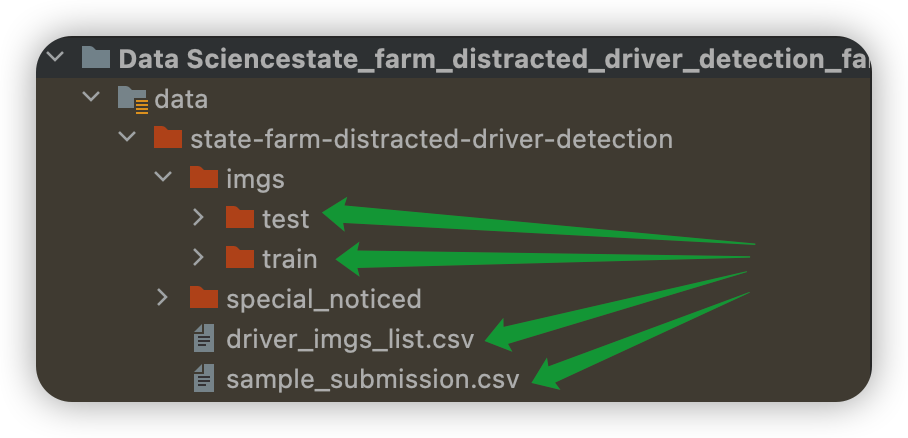

In [9]:
# Implementation
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
print(f"Training dataset shape: {train_df.shape}")
print(f"Testing dataset shape: {test_df.shape}")

print("\nCheck if the data is still balanced after splitting\n")
print(train_df['classname'].value_counts(normalize=True))
print(test_df['classname'].value_counts(normalize=True))

Training dataset shape: (17939, 3)
Testing dataset shape: (4485, 3)

Check if the data is still balanced after splitting

classname
c0    0.112102
c3    0.104409
c5    0.104298
c2    0.103462
c4    0.103183
c6    0.102626
c1    0.099727
c9    0.095658
c7    0.089749
c8    0.084787
Name: proportion, dtype: float64
classname
c6    0.107915
c0    0.106577
c1    0.106577
c4    0.105909
c3    0.105463
c2    0.102787
c5    0.098328
c9    0.092085
c7    0.087402
c8    0.086957
Name: proportion, dtype: float64


## 2. Model Selection / Experiments
We are quite new to this area, so let's do some experiments. James have provided some links he found seems to be helpful.

Resources:
> 1. Tenserflow has a lot of interesting examples here.
https://www.tensorflow.org/lite/examples
One that might be useful for you guys is this gesture recognition one
https://github.com/tensorflow/examples/tree/master/lite/examples/gesture_classification/android

> 2. Also check out the section here on using Google’s TeachableMachines
https://github.com/jfd235/Interactive-Lab-Hub/tree/Fall2022/Lab%205

> 3. These articles seem to point to repositories that already have code in Colab/Jupyter notebook form
https://towardsdatascience.com/tutorial-using-deep-learning-and-cnns-to-make-a-hand-gesture-recognition-model-371770b63a51
https://developers.google.com/mediapipe/solutions/customization/gesture_recognizer

Final Note from James:
> There are a ton of resources out there like this, so I’d pick one that looks easy (the TeachableMachines looks really easy to prototype with IMO), try it with a few of your images for training (no point in using all of them since we’re just testing things for now), and see if they can predict a few of your other images for testing

### 2.1 Experiements Report for those sources
Don't have to be only one assignee.
Assignee: